# Detecção de câncer de mama em imagens médicas

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("forderation/breakhis-400x")

print("Path to dataset files:", path)

100%|██████████| 803M/803M [00:09<00:00, 92.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/forderation/breakhis-400x/versions/1


Importando as bibliotecas que serão usadas

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2

Montagem dos dataframes de treino e de teste

In [ ]:
import os
import pandas as pd

base_path = os.path.join(path, "BreaKHis 400X")

def build_df(base_path, split):
    filepaths = []
    labels = []
    for cls in ['benign', 'malignant']:
        folder = os.path.join(base_path, split, cls)
        for f in os.listdir(folder):
            if f.endswith(".png") or f.endswith(".jpg"):
                filepaths.append(os.path.join(split, cls, f))
                labels.append(0 if cls=='benign' else 1)
    return pd.DataFrame({'filepath': filepaths, 'label': labels})

train_df = build_df(base_path, "train")
test_df   = build_df(base_path, "test")


In [ ]:
train_df.head()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  1148 non-null   object
 1   label     1148 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.1+ KB


In [ ]:
test_df.head()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  545 non-null    object
 1   label     545 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.6+ KB


In [ ]:
print("Treino:")
print(train_df['label'].value_counts())
print(train_df['label'].value_counts(normalize=True))

print("\nTeste:")
print(test_df['label'].value_counts())
print(test_df['label'].value_counts(normalize=True))

Treino:
label
1    777
0    371
Name: count, dtype: int64
label
1    0.676829
0    0.323171
Name: proportion, dtype: float64

Teste:
label
1    369
0    176
Name: count, dtype: int64
label
1    0.677064
0    0.322936
Name: proportion, dtype: float64


Distribuição das classes nos dois conjuntos, nota-se um desbalanceamento nos dados, tanto no conjunto de treino e de teste. Cerca de 68% dos dados são de imagens com tumores malignos e 32% para imagens de tumores benignos.

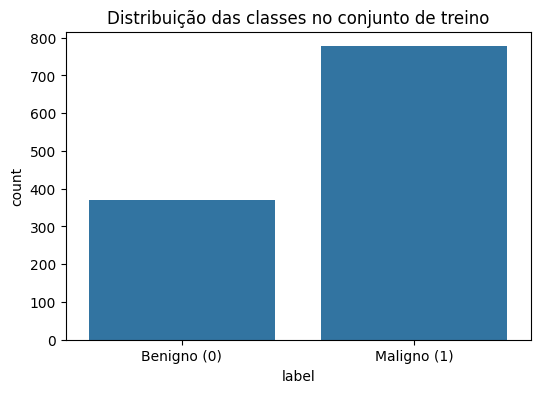

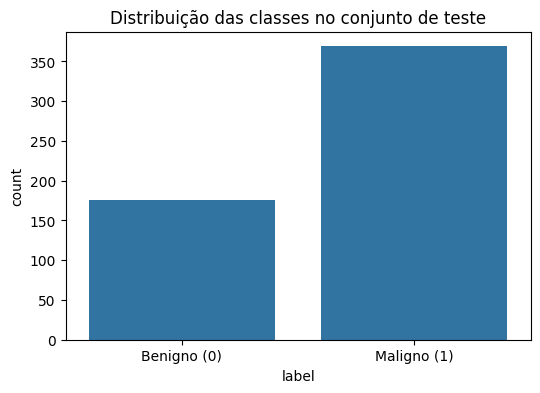

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=train_df)
plt.title("Distribuição das classes no conjunto de treino")
plt.xticks([0,1], ["Benigno (0)", "Maligno (1)"])
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='label', data=test_df)
plt.title("Distribuição das classes no conjunto de teste")
plt.xticks([0,1], ["Benigno (0)", "Maligno (1)"])
plt.show()

## Geração das imagens para treino e teste.

Aqui, definimos o formato de geração das imagens do treino. Estamos aplicado normalização e data augmentation para evitar overfitting:
- **rescale=1./255** -> normaliza os valores dos pixels
- **rotation_range=15** -> permite rotações aleatórias das imagens em até 15 graus
- **width_shift_range=0.2** -> desloca horizontalmente a imagem em até 20% da largura de sua largura.
- **height_shift_range=0.2** -> semelhante ao anterior, mas agora na vertical.
- **shear_range=0.2** -> aplica um corte inclinado de até 20%.
- **zoom_range=0.2** -> aplica zoom in/out (aproxima/afasta) aleatoriamente de até 20% da imagem.
- **horizontal_flip=True** -> permite inverter a imagem horizontalmente.
- **vertical_flip=True** -> semelhante ao anterior, mas agora na vertical.
- **fill_mode='nearest'** -> se houver corte, a imagem é preenchida com os valores próximos aos da borda.

Isso permite que, durante o treino, o modelo possa generalizar melhor, sem decorar os pixels da imagem, e sim aprender padrões relevantes para diagnóstico.

Na geração das imagens de teste, só aplica-se a normalização, permitindo medir o desempenho real do modelo sem distorção nas imagens.



In [ ]:
train_dir = f"{base_path}/train"
test_dir  = f"{base_path}/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 36

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

Agora, há a aplicação das regras de geração das imagens definidas anteriormente:
- **target_size=IMG_SIZE** -> Redimensiona todas as imagens para 224x224.
- **batch_size=BATCH_SIZE** -> Define quantas imagens serão geradas por batch.
- **class_mode='categorical'** -> Gera um vetor one-hot para classificação entre benigno e maligno.
- **shuffle** -> Na geração para treino, aplica-se o embaralhamento para evitar que o modelo decore a sequência das imagens, já no teste, isso não é ncessário.



In [ ]:
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1148 images belonging to 2 classes.
Found 545 images belonging to 2 classes.


Visualização de algumas imagens já geradas pelo ImageDataGenerator:

In [ ]:
def show_images(generator, df, img_size=(224,224), batch_size=BATCH_SIZE, n_show=12):

    imgs, labels = next(generator)
    plt.figure(figsize=(15, 8))

    for i in range(n_show):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(imgs[i])
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis("off")

    plt.show()

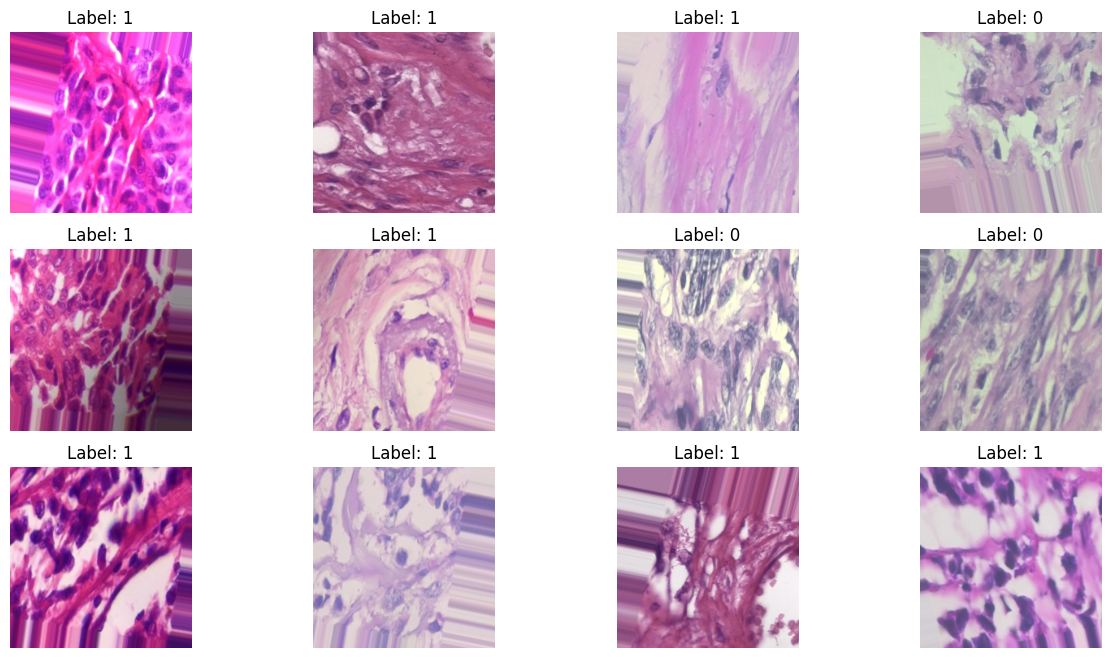

In [ ]:
show_images(train_gen, train_df, n_show=12)

## Sobre ResNetV2

A ResNetV2 foi proposto em 2016 no artigo "**Identify Mappings in Deep Residual Networks (Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun)**" como uma evolução da ResNetV1, proposto em 2015, e nasce como uma tentativa de entender mais a fundo o porque que a ResNetV1 funcionava e como poderia melhorá-la ainda mais.

Na primeira versão da ResNet, foi-se introduzido o conceito de blocos residuais e skip connections que permitiam o treinamento de redes profundas.

### Mas o que são blocos residuais e skip connections?

Antes da ResNet, acreditava-se que empilhar camadas e mais camadas em uma rede neural sempre levaria a uma melhoria de desempenho. Porém, na prática, notou-se que:
- Redes muito profundas tinham uma menor precisão nos conjuntos de teste e treino em comparação com redes mais rasas;
- Isso não era um problema de overfitting, pois a rede não conseguia aprender nem os dados de treino, e sim de otimização: não era possível treinar de forma eficiente essas redes devido ao **exploding gradient** (explosão dos gradientes durante o backpropagation).

Assim, nascem os blocos residuais com uma solução para esse problema: a **skip connection**. Ela permite que a informação importante pule algumas camadas, auxiliando para que a rede não se perca e possa aprender de forma mais eficiente.

### O que mudou da primeira versão para a segunda?

Acreditava-se que a ResNetV1 funcionava muito bem devido aos caminhos diretos que as skip connections criavam para o fluxo da informação, porém, durante a análise da prmeira versão, notou-se que sua arquitetura na verdade atrapalhava o fluxo ideal da informação:
- Na ResNetV1 (a), as operações de **normalização(BatchNorm)** e **ativação(ReLU)** estavam no caminho principal;
- Quando o gradiente retropropagava, passava pela função residual e pelo caminho skip, porém, ele era modificado por uma operação ReLU após a adição.

Essas operações acabavam sendo obstáculos para o fluxo livre da informação, principalmente ao tratar de redes com mais de 1000 camadas.

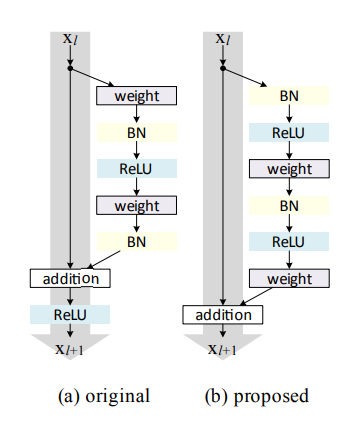

Assim, nasce a ideia que deu origem ao artigo da ResNetV2 (b): reorganizar a ordem das operações para conseguir liberar o skip connection de qualquer obstáculo, ou seja, mover todas as operações de normalização e ativação para antes das convoluções, e a isso se deu o nome de **Pré-Ativação**.

Assim, a ResNetV2 mostrou-se como um refinamento da versão original, com a melhora do fluxo da informação através da pré-ativação.

## Modelo

No modelo, decidimos utilizar uma rede pré-treinada, já que o dataset é pequeno.

Escolhemos então o ResNet50V2, pois ele utiliza no seu treinamento imagens do ImageNet, aprendendo features genéricas, como bordas e texturas que tendem a funcionar bem em imagens médicas. Além disso, é uma rede forte contra o desvanecimendo do gradiente, graças aos blocos residuais, permitindo treinar redes profundas mesmo com datasets pequenos.

1- Ignoramos as camadas densas de classificação da rede pré-treinada, já que só queremos o extrator de características.

2- Congelamos a base, impedindo que os pesos do modelo pré-treinado sejam atualizados inicialmente, já que sabemos que ele já aprendeu features importantes, permitindo que o modelo aprenda apenas as camadas finais adaptadas ao nosso problema.

3- Reduzimos o mapa de features 3D para um vetor 1D, à fim de evitar overfitting.

4- Criamos uma camada totalmente conectada de 512 neurônios, que permite ao modelo combinar as características que já foram aprendidas na base em padrões específicos do nosso problema.

5- Desligamos 50% dos neurônios de forma aleatória durante o treino, evitando que a rede memorize imagens.

6- Camada final com duas saídas.

In [ ]:
# 1
base_model = ResNet50V2(include_top=False, input_shape=(*IMG_SIZE, 3), weights='imagenet')

# 2
base_model.trainable = False

# 3
x = GlobalAveragePooling2D()(base_model.output)

# 4
x = Dense(512, activation='relu')(x)

# 5
x = Dropout(0.5)(x)

# 6
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# for layer in base_model.layers:
#     layer.trainable = False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Para o treinamento, escolhemos as seguintes configurações:
- **optimizer=Adam(learning_rate=1e-4)** -> Taxa de aprendizado para cada peso nem tão alta, para evitar oscilação, nem tão baixa, para aumentar a velocidade do treinamento.
- **loss='caregorical_crossentropy'** -> Mede a diferença entre a distribuição real e a prevista dos dados.
- **metrics=['accuracy', tf.keras.metrics.AUC()]** -> Usadas pra monitorar o desempenho durante o treino.

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

Alguns callbacks se fazem necessário, tanto pra evitar overfitting quanto pra economizar tempo de treinamento:
- **EarlyStopping** -> Usado para interromper o treinamento antes de completar todas as épocas;
  - **patience=5** -> Espera 5 épocas sem melhora antes de parar;
  - **restore_best_weights=True** -> Após a parada, volta com os pesos da melhor época;
  - **monitor='val_loss'** -> Verifica a perda na validação para a decisão de parada;
  - **mode='min'** -> Quanto menor o valor do val_loss, melhor;
  - **min_delta=0.001** -> A melhora só é considerada se a perda cair pelo menos 0.001.
- **ReduceLROnPlateau** -> Maneira de reduzir a taxa de aprendizado durante o treinamento quando o modelo estagnar.
  - **factor=0.1** -> Ao notar a estagnação, multiplica o  learning rate por 0.1;
  - **patience=3** -> Espera 3 épocas sem melhora antes de reduzir;
  - **monitor=val_loss** -> Como no EarlyStopping, utiliza o val_loss para decidir se reduz a taxa de aprendizado;
  - **mode='min'** -> O mesmo que para o EarlyStopping.

In [ ]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss', mode='min', min_delta=0.001),
    ReduceLROnPlateau(factor=0.1, patience=3, monitor='val_loss', mode='min')
]

Finalmente, chegamos na etapa de iniciação ao treinamento e todas as configurações definidas anteriomente serão usadas.

In [ ]:
history = model.fit(
    train_gen,
    epochs=60,
    validation_data=test_gen,
    callbacks=callbacks
)

model.save('modelo.h5')
files.download('modelo.h5')

import pickle

with open("history.pkl", "wb") as f:
    pickle.dump(history.history, f)

from google.colab import files
files.download("history.pkl")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 319s 10s/step - accuracy: 0.5504 - auc: 0.5699 - loss: 0.8908 - val_accuracy: 0.7468 - val_auc: 0.8172 - val_loss: 0.5274 - learning_rate: 1.0000e-04
Epoch 2/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 306s 10s/step - accuracy: 0.7224 - auc: 0.7899 - loss: 0.5765 - val_accuracy: 0.7633 - val_auc: 0.8441 - val_loss: 0.4938 - learning_rate: 1.0000e-04
Epoch 3/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 304s 10s/step - accuracy: 0.7622 - auc: 0.8362 - loss: 0.5138 - val_accuracy: 0.7725 - val_auc: 0.8550 - val_loss: 0.4783 - learning_rate: 1.0000e-04
Epoch 4/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 323s 10s/step - accuracy: 0.7753 - auc: 0.8593 - loss: 0.4724 - val_accuracy: 0.7872 - val_auc: 0.8599 - val_loss: 0.4756 - learning_rate: 1.0000e-04
Epoch 5/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 302s 10s/step - accuracy: 0.7682 - auc: 0.8552 - loss: 0.4854 - val_accuracy: 0.7963 - val_auc: 0.8703 - val_loss: 0.4559 - learning_rate: 1.0000e-04
Epoch 6/60
32/32 ━━━━━━━━━━━━━━━━━━━━ 302s 9s/step - accurac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

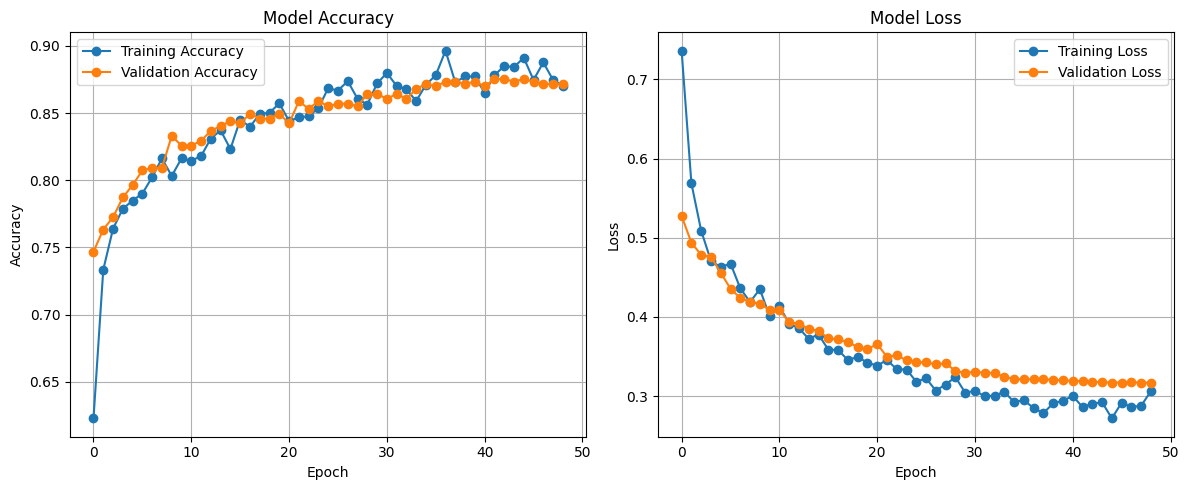

In [ ]:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

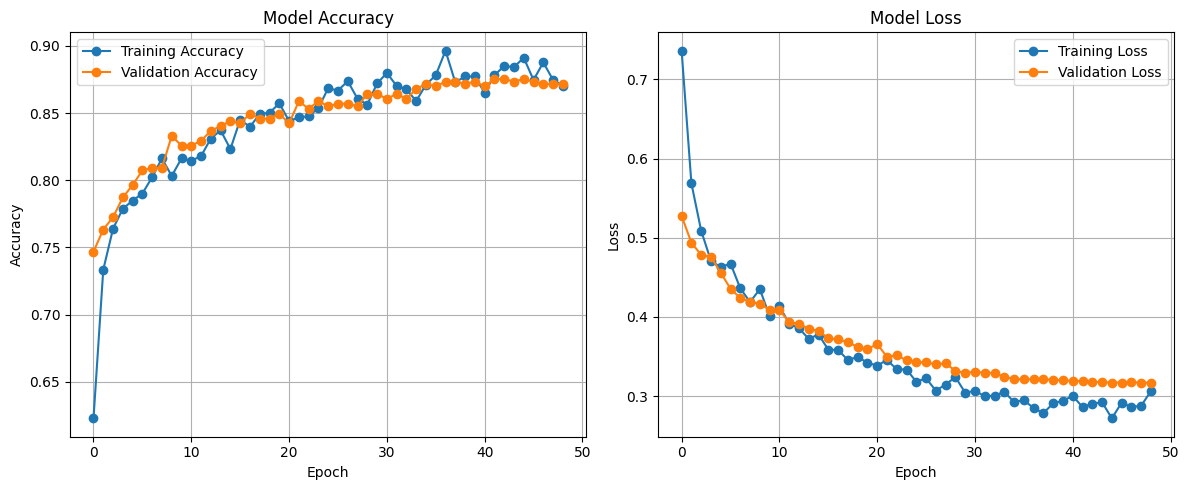

In [ ]:
from tensorflow.keras.models import load_model

with open('/content/drive/MyDrive/Projeto_IA/history.pkl', 'rb') as f:
    history2 = pickle.load(f)
model = load_model('/content/drive/MyDrive/Projeto_IA/modelo2.h5')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history2['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history2['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history2['loss'], label='Training Loss', marker='o')
plt.plot(history2['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()